In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [936]:
class NeuralNetwork:
    def __init__(self, layers, activation,optimiser='momentum', beta=0.9, weights_initialize=None):
        """
        :param layers: A list specifying the number of neurons in each layer.
        :param activation: The activation function to use in the hidden layers.
        :param weights_initialize: Type of weight initialization (e.g., He, Xavier). If None -> random from uniform distribuiton U([0,1])
        :momentum: Beta parameter for momentum optimiser
        """

        self.layers = layers
        self.weights = []
        self.bias = []
        self.beta = beta
        self.optimiser=optimiser
        if(optimiser=='momentum'):
            print('Chosen optimiser: Momentum')
        elif(optimiser=="RMSProp"):
            print('Chosen optimiser: RMSProp')
        else:
            print("No optimiser chosen")
       
   
        for i in range(len(layers)-1):
            if weights_initialize == "Xavier":
                std = np.sqrt(2 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            elif weights_initialize == "He":
                std = np.sqrt(2 / layers[i])
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            else:
                self.weights.append(np.random.uniform(-0.5, 0.5, size=(layers[i], layers[i+1])))
            

        self.bias = [np.random.uniform(-0.5, 0.5, size=(layers[i+1],)) for i in range(len(layers)-1)]
        
        self.velocity_weights = [np.zeros_like(w) for w in self.weights]
        self.velocity_biases = [np.zeros_like(b) for b in self.bias]

        self.rms_weights = [np.full_like(w, 1e-8) for w in self.weights]
        self.rms_biases = [np.full_like(b, 1e-8) for b in self.bias]

        activation_functions = {
            "sigmoid": self.sigmoid,
            "tanh": self.tanh,
            "relu": self.relu,
            "leaky_relu": self.leaky_relu
        }

        activation_functions_derivatives = {
            "sigmoid": self.sigmoid_derivative,
            "tanh": self.tanh_derivative,
            "relu":self.relu_derivative,
            "leaky_relu":self.leaky_relu

        }

        self.activation_function = activation_functions.get(activation)
        self.activation_function_derivative=activation_functions_derivatives.get(activation)

    #activation functions
    def sigmoid(self, x): 
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x): return x * (1 - x)
    
    def tanh(self, x): return np.tanh(x)
    def tanh_derivative(self, x): return 1-x**2

    def relu(self,x):return np.maximum(0, x)

    def relu_derivative(self,x):
        return (x > 0).astype(int)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)

    def leaky_relu_derivative(self, x, alpha=0.01):
            return np.where(x > 0, 1, alpha)
    
   
    
    def forward(self, X):
        self.a = [X]
        self.z = [X]
        for i in range(len(self.weights)-1):
            z = np.dot(self.a[-1], self.weights[i]) + self.bias[i]
            self.z.append(z)
            a = self.activation_function(z)
            self.a.append(a)

        z = np.dot(self.a[-1], self.weights[-1]) + self.bias[-1]
        self.z.append(z)
        self.a.append(z)
        return self.a[-1]

    def backpropagate(self, X, y, learning_rate):
        m = X.shape[0]
        delta = (self.forward(X) - y)/m 
        
        for i in reversed(range(len(self.weights))):
            
            delta_weights = np.dot(self.a[i].T, delta)
            delta_bias = np.sum(delta, axis=0)
            clip_value=1.0
            delta_weights = np.clip(delta_weights, -clip_value, clip_value)
            delta_bias = np.clip(delta_bias, -clip_value, clip_value)

            if self.optimiser=='momentum':
                
                self.velocity_weights[i] = self.beta*self.velocity_weights[i] + learning_rate*delta_weights
                self.velocity_biases[i] = self.beta*self.velocity_biases[i] + learning_rate*delta_bias
                self.weights[i] -= self.velocity_weights[i]
                self.bias[i] -= self.velocity_biases[i]
                
            elif self.optimiser=='RMS':
                
                epsilon = 1e-8
                self.rms_weights[i] = self.beta*self.rms_weights[i] + (1-self.beta)*np.square(delta_weights)
                self.rms_biases[i] = self.beta*self.rms_biases[i] + (1-self.beta)*np.square(delta_bias)
               
                self.weights[i] -= learning_rate*delta_weights/(np.sqrt(self.rms_weights[i]+epsilon))
                self.bias[i] -= learning_rate*delta_bias/(np.sqrt(self.rms_biases[i]+epsilon))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_function_derivative(self.z[i])
            
            


    def train(self, X_train, y_train, X_test, y_test, y_scaler, learning_rate, epochs,mse_threshold, batch_size=32, plot=True):
        train_losses = []
        test_losses=[]
        for epoch in range(epochs):
            if batch_size is None: 
                self.forward(X_train)
                self.backpropagate(X_train, y_train, learning_rate)
            else:
                permutation = np.random.permutation(X_train.shape[0]) #mini-batch
                for i in range(0, X_train.shape[0], batch_size):
                    indices = permutation[i:i+batch_size]
                    X_batch = X_train[indices]
                    y_batch = y_train[indices]
                    self.forward(X_batch)
                    self.backpropagate(X_batch, y_batch, learning_rate)
            

            train_loss = self.MSE(X_train, y_train)
            train_losses.append(train_loss)
   

        
            if epoch % 100 == 0:
            
                Y_pred_denorm=y_scaler.inverse_transform(self.predict(X_test))
                mse = np.mean((Y_pred_denorm - y_test) ** 2)
                test_losses.append(mse)
                if plot:
                    print(f"Epoch {epoch}, Training Loss: {train_loss:.6f}, test MSE: {mse}")
                
                if mse<=mse_threshold:
                    print(f"TEST MSE ACHIEVED: {mse}, epoch{epoch}")
                    break
            
            if plot and epoch%10000 ==0:
                plt.scatter(X_test, y_test)
                plt.scatter(X_test, Y_pred_denorm)
                plt.title(f'MSE = {mse} dla epoki {epoch}')
                plt.show()

          
        plot_losses = test_losses[10:(len(test_losses)-1)]    
        plt.plot(plot_losses)
        plt.xlabel("Epoki / 100")
        plt.ylabel("MSE")
        plt.title("Wykres Test MSE podczas treningu od 1000 epoki")
        plt.show()

        
        plt.plot(train_losses)
        plt.xlabel("Epoki / 100")
        plt.ylabel("MSE na zbiorze znormalizowanym")
        plt.title("Wykres MSE podczas całego treningu")
        plt.show()
        
        

    def predict(self, X):
        return self.forward(X)
    
    def MSE(self, X, Y):
        return np.mean((self.predict(X) - Y) ** 2)

# Suqare large

In [558]:
train_df = pd.read_csv('data/square-large-training.csv')
test_df = pd.read_csv('data/square-large-test.csv')

X_train, Y_train=train_df['x'].to_numpy().reshape(-1,1), train_df['y'].to_numpy().reshape(-1,1)
X_test, Y_test=test_df['x'].to_numpy().reshape(-1,1), test_df['y'].to_numpy().reshape(-1,1)

In [559]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_normalized = x_scaler.fit_transform(X_train.reshape(-1, 1))
Y_train_normalized = y_scaler.fit_transform(Y_train.reshape(-1, 1))

X_test_normalized = x_scaler.transform(X_test.reshape(-1,1))
Y_test_normalized = y_scaler.transform(Y_test.reshape(-1,1))

### Try 1

Chosen optimiser: Momentum
Epoch 0, Training Loss: 0.836972, test MSE: 104479.51344494097


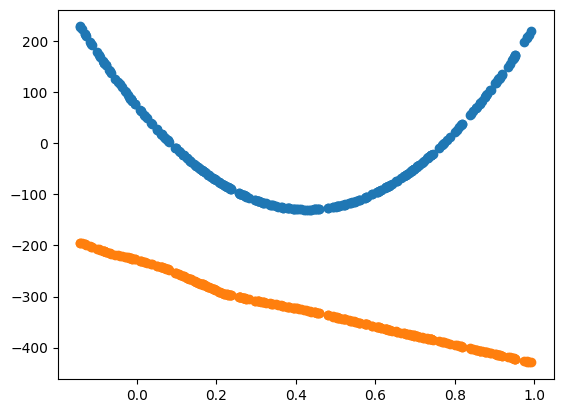

Epoch 100, Training Loss: 0.022592, test MSE: 5225.334592575539
Epoch 200, Training Loss: 0.012034, test MSE: 3127.8833262154294
Epoch 300, Training Loss: 0.006888, test MSE: 1984.8686313474377
Epoch 400, Training Loss: 0.004673, test MSE: 1458.580303399425
Epoch 500, Training Loss: 0.003490, test MSE: 1185.2462539850815
Epoch 600, Training Loss: 0.002715, test MSE: 1007.104446178231
Epoch 700, Training Loss: 0.002148, test MSE: 874.8773908020688
Epoch 800, Training Loss: 0.001712, test MSE: 763.4342961403748
Epoch 900, Training Loss: 0.001388, test MSE: 665.0320320951978
Epoch 1000, Training Loss: 0.001150, test MSE: 583.3566606705657
Epoch 1100, Training Loss: 0.000971, test MSE: 516.7413884751475
Epoch 1200, Training Loss: 0.000835, test MSE: 460.87714969921234
Epoch 1300, Training Loss: 0.000727, test MSE: 415.4215319962841
Epoch 1400, Training Loss: 0.000641, test MSE: 376.60650820359365
Epoch 1500, Training Loss: 0.000571, test MSE: 343.5723374489476
Epoch 1600, Training Loss: 0.

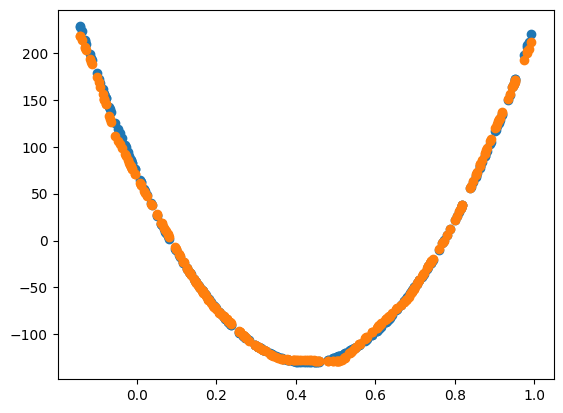

Epoch 10100, Training Loss: 0.000036, test MSE: 11.206186795577311
Epoch 10200, Training Loss: 0.000036, test MSE: 10.92601490181768
Epoch 10300, Training Loss: 0.000035, test MSE: 10.644934346883225
Epoch 10400, Training Loss: 0.000035, test MSE: 10.38377503509709
Epoch 10500, Training Loss: 0.000035, test MSE: 10.139994119058104
Epoch 10600, Training Loss: 0.000034, test MSE: 9.894027616266277
Epoch 10700, Training Loss: 0.000034, test MSE: 9.663894678974762
Epoch 10800, Training Loss: 0.000034, test MSE: 9.436448819129858
Epoch 10900, Training Loss: 0.000033, test MSE: 9.241288320414332
Epoch 11000, Training Loss: 0.000033, test MSE: 9.033720122970538
Epoch 11100, Training Loss: 0.000033, test MSE: 8.849865367075893
Epoch 11200, Training Loss: 0.000033, test MSE: 8.663517012970182
Epoch 11300, Training Loss: 0.000032, test MSE: 8.485759236512527
Epoch 11400, Training Loss: 0.000032, test MSE: 8.316886529283165
Epoch 11500, Training Loss: 0.000032, test MSE: 8.156667264509354
Epoch 1

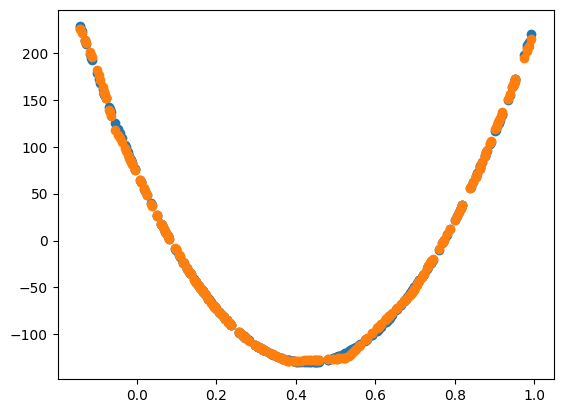

Epoch 20100, Training Loss: 0.000020, test MSE: 3.4282566812246817
Epoch 20200, Training Loss: 0.000020, test MSE: 3.422117450141534
Epoch 20300, Training Loss: 0.000020, test MSE: 3.4163163521845625
Epoch 20400, Training Loss: 0.000020, test MSE: 3.4098058437944703
Epoch 20500, Training Loss: 0.000020, test MSE: 3.404437946994749
Epoch 20600, Training Loss: 0.000020, test MSE: 3.3979799416793464
Epoch 20700, Training Loss: 0.000020, test MSE: 3.392740545122245
Epoch 20800, Training Loss: 0.000020, test MSE: 3.387893894292494
Epoch 20900, Training Loss: 0.000020, test MSE: 3.382535681783857
Epoch 21000, Training Loss: 0.000020, test MSE: 3.3771323262367887
Epoch 21100, Training Loss: 0.000020, test MSE: 3.372644143034008
Epoch 21200, Training Loss: 0.000020, test MSE: 3.368082809734278
Epoch 21300, Training Loss: 0.000019, test MSE: 3.362646616151067
Epoch 21400, Training Loss: 0.000019, test MSE: 3.358628435727171
Epoch 21500, Training Loss: 0.000019, test MSE: 3.3540633173579244
Epoc

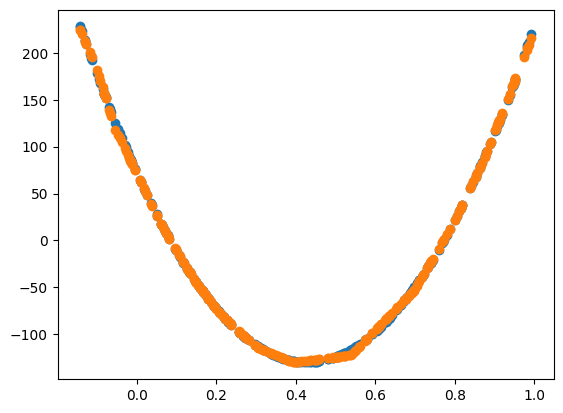

Epoch 30100, Training Loss: 0.000015, test MSE: 3.017154861206982
Epoch 30200, Training Loss: 0.000015, test MSE: 3.016320559929642
Epoch 30300, Training Loss: 0.000015, test MSE: 3.0174482016839645
Epoch 30400, Training Loss: 0.000015, test MSE: 3.014781892413126
Epoch 30500, Training Loss: 0.000015, test MSE: 3.0120349328329046
Epoch 30600, Training Loss: 0.000015, test MSE: 3.0057971720074272
Epoch 30700, Training Loss: 0.000015, test MSE: 3.002540664046861
Epoch 30800, Training Loss: 0.000015, test MSE: 2.9988744411143893
TEST MSE ACHIEVED: 2.9988744411143893, epoch30800


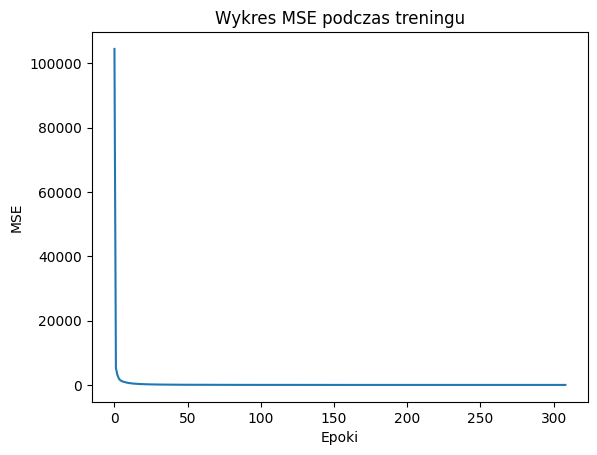

In [735]:
nn = NeuralNetwork(layers=[1,20,25,1], activation='relu',optimiser='momentum',beta=0.9, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.019, batch_size=256, epochs=60000, mse_threshold=3)


## Try 2 mse=1.09

Chosen optimiser: Momentum
Epoch 0, Training Loss: 0.199865, test MSE: 22958.11220177736


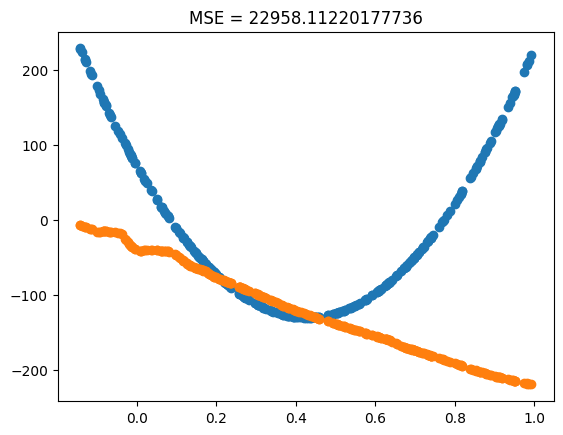

Epoch 100, Training Loss: 0.014574, test MSE: 1503.8073990102382
Epoch 200, Training Loss: 0.003725, test MSE: 556.9724906156656
Epoch 300, Training Loss: 0.000655, test MSE: 84.58903501926787
Epoch 400, Training Loss: 0.000358, test MSE: 41.06110656793327
Epoch 500, Training Loss: 0.000196, test MSE: 20.769221562698778
Epoch 600, Training Loss: 0.000135, test MSE: 14.166077531927021
Epoch 700, Training Loss: 0.000101, test MSE: 10.664575217312152
Epoch 800, Training Loss: 0.000080, test MSE: 8.677127010530208
Epoch 900, Training Loss: 0.000066, test MSE: 7.354538549199533
Epoch 1000, Training Loss: 0.000056, test MSE: 6.432956270867817
Epoch 1100, Training Loss: 0.000049, test MSE: 5.716917884121358
Epoch 1200, Training Loss: 0.000044, test MSE: 5.123878933523318
Epoch 1300, Training Loss: 0.000039, test MSE: 4.637793719450401
Epoch 1400, Training Loss: 0.000036, test MSE: 4.227353479079702
Epoch 1500, Training Loss: 0.000033, test MSE: 3.8663120946510463
Epoch 1600, Training Loss: 0.

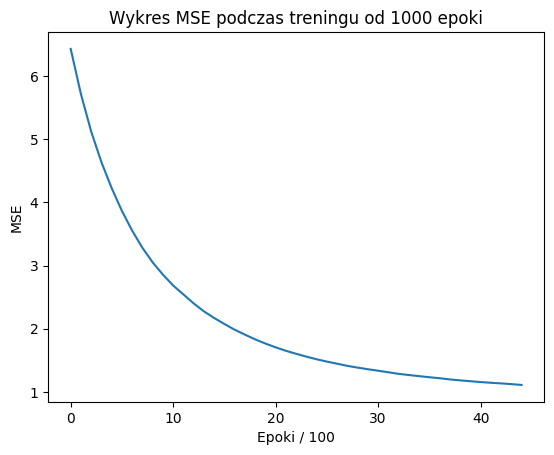

In [792]:
nn = NeuralNetwork(layers=[1,27,30,1], activation='relu',optimiser='momentum',beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0013, batch_size=512, epochs=60000, mse_threshold=1.1)


## Try 3 mse=1.83

Chosen optimiser: Momentum
Epoch 0, Training Loss: 1.967718, test MSE: 256018.40431432257


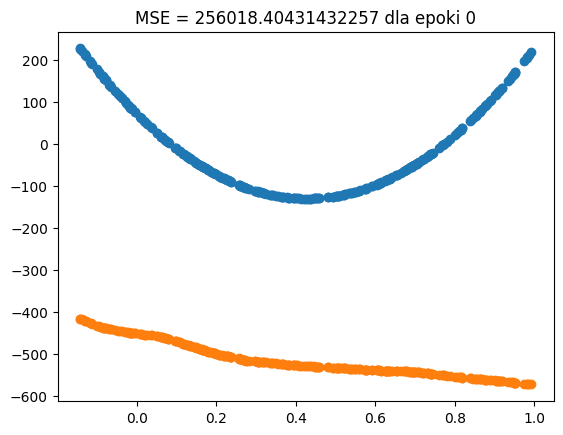

Epoch 100, Training Loss: 0.092434, test MSE: 14535.572314584548
Epoch 200, Training Loss: 0.010188, test MSE: 1025.2353928848154
Epoch 300, Training Loss: 0.001942, test MSE: 218.3008362696895
Epoch 400, Training Loss: 0.000686, test MSE: 113.92049266585357
Epoch 500, Training Loss: 0.000350, test MSE: 64.1712836175835
Epoch 600, Training Loss: 0.000239, test MSE: 42.65568826644187
Epoch 700, Training Loss: 0.000175, test MSE: 34.31155960407691
Epoch 800, Training Loss: 0.000137, test MSE: 28.58617934770568
Epoch 900, Training Loss: 0.000111, test MSE: 25.42593936297491
Epoch 1000, Training Loss: 0.000093, test MSE: 22.65101504571791
Epoch 1100, Training Loss: 0.000080, test MSE: 20.652700573210968
Epoch 1200, Training Loss: 0.000070, test MSE: 19.015289315114746
Epoch 1300, Training Loss: 0.000063, test MSE: 17.662922694404152
Epoch 1400, Training Loss: 0.000057, test MSE: 16.49556331192561
Epoch 1500, Training Loss: 0.000052, test MSE: 15.462404439226521
Epoch 1600, Training Loss: 0

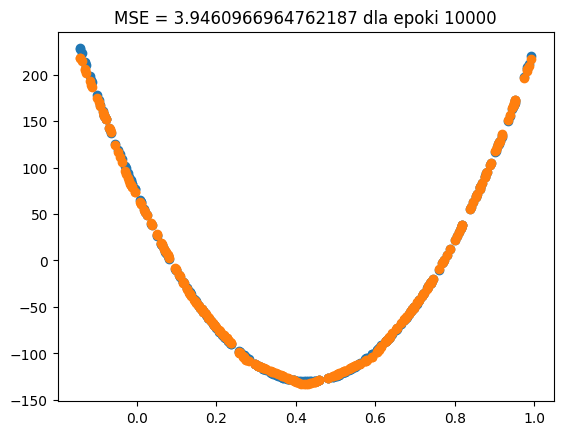

Epoch 10100, Training Loss: 0.000010, test MSE: 3.9264528972546966
Epoch 10200, Training Loss: 0.000010, test MSE: 3.907805350776655
Epoch 10300, Training Loss: 0.000010, test MSE: 3.888054587378057
Epoch 10400, Training Loss: 0.000010, test MSE: 3.8722513502692655
Epoch 10500, Training Loss: 0.000009, test MSE: 3.8570985351731246
Epoch 10600, Training Loss: 0.000009, test MSE: 3.8414027623504263
Epoch 10700, Training Loss: 0.000009, test MSE: 3.8280062419863072
Epoch 10800, Training Loss: 0.000009, test MSE: 3.8080873798578705
Epoch 10900, Training Loss: 0.000009, test MSE: 3.78972808918072
Epoch 11000, Training Loss: 0.000009, test MSE: 3.7676868911881933
Epoch 11100, Training Loss: 0.000009, test MSE: 3.752083437893709
Epoch 11200, Training Loss: 0.000009, test MSE: 3.736020574612794
Epoch 11300, Training Loss: 0.000009, test MSE: 3.7190594261519245
Epoch 11400, Training Loss: 0.000009, test MSE: 3.7061963180091553
Epoch 11500, Training Loss: 0.000009, test MSE: 3.6908108390380874
E

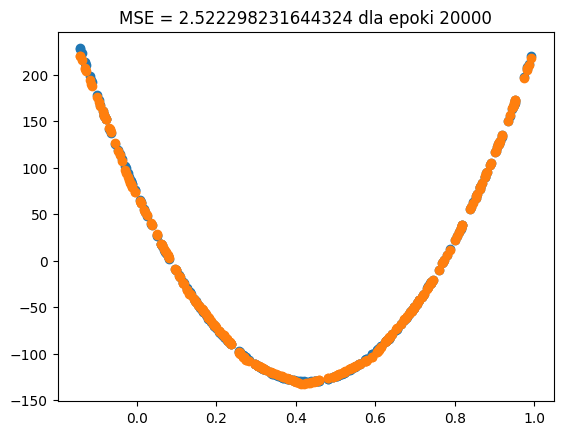

Epoch 20100, Training Loss: 0.000006, test MSE: 2.520045543235437
Epoch 20200, Training Loss: 0.000006, test MSE: 2.51686243628948
Epoch 20300, Training Loss: 0.000006, test MSE: 2.512555139611693
Epoch 20400, Training Loss: 0.000006, test MSE: 2.5081229151374247
Epoch 20500, Training Loss: 0.000006, test MSE: 2.5040111937076865
Epoch 20600, Training Loss: 0.000006, test MSE: 2.504847817746867
Epoch 20700, Training Loss: 0.000006, test MSE: 2.499973998245704
Epoch 20800, Training Loss: 0.000006, test MSE: 2.4930453386184284
Epoch 20900, Training Loss: 0.000006, test MSE: 2.4852239257169924
Epoch 21000, Training Loss: 0.000006, test MSE: 2.479356976526186
Epoch 21100, Training Loss: 0.000006, test MSE: 2.473057056167706
Epoch 21200, Training Loss: 0.000006, test MSE: 2.467135157958746
Epoch 21300, Training Loss: 0.000006, test MSE: 2.4621348310105087
Epoch 21400, Training Loss: 0.000006, test MSE: 2.458066695420813
Epoch 21500, Training Loss: 0.000006, test MSE: 2.4542485751535197
Epoch

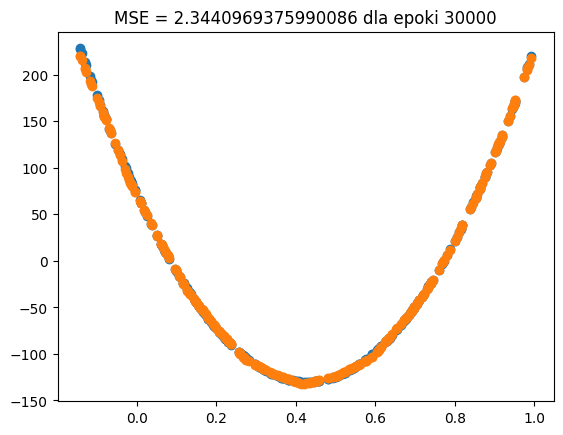

Epoch 30100, Training Loss: 0.000005, test MSE: 2.3445884570768114
Epoch 30200, Training Loss: 0.000005, test MSE: 2.342953861896373
Epoch 30300, Training Loss: 0.000005, test MSE: 2.341838187075842
Epoch 30400, Training Loss: 0.000005, test MSE: 2.3424408869368962
Epoch 30500, Training Loss: 0.000005, test MSE: 2.3422998542910083
Epoch 30600, Training Loss: 0.000005, test MSE: 2.3379343290200625
Epoch 30700, Training Loss: 0.000005, test MSE: 2.3315108369846973
Epoch 30800, Training Loss: 0.000005, test MSE: 2.3261635096058026
Epoch 30900, Training Loss: 0.000005, test MSE: 2.322613068297247
Epoch 31000, Training Loss: 0.000005, test MSE: 2.3198733949068835
Epoch 31100, Training Loss: 0.000005, test MSE: 2.3159446906655408
Epoch 31200, Training Loss: 0.000005, test MSE: 2.313513089705859
Epoch 31300, Training Loss: 0.000005, test MSE: 2.3093003606897637
Epoch 31400, Training Loss: 0.000005, test MSE: 2.3054774853477498
Epoch 31500, Training Loss: 0.000005, test MSE: 2.3035259570164253

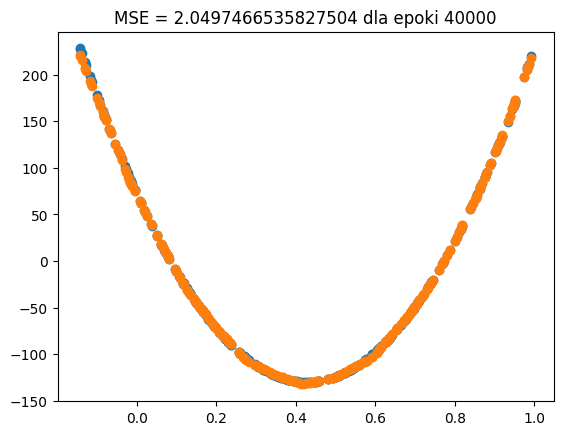

Epoch 40100, Training Loss: 0.000004, test MSE: 2.0465007527157377
Epoch 40200, Training Loss: 0.000004, test MSE: 2.0442912447243042
Epoch 40300, Training Loss: 0.000004, test MSE: 2.0408125463013267
Epoch 40400, Training Loss: 0.000004, test MSE: 2.038086004876075
Epoch 40500, Training Loss: 0.000004, test MSE: 2.0370059460546854
Epoch 40600, Training Loss: 0.000004, test MSE: 2.033852714413192
Epoch 40700, Training Loss: 0.000004, test MSE: 2.0277397239061434
Epoch 40800, Training Loss: 0.000004, test MSE: 2.020258714814069
Epoch 40900, Training Loss: 0.000004, test MSE: 2.0172618201002956
Epoch 41000, Training Loss: 0.000004, test MSE: 2.0126396924336856
Epoch 41100, Training Loss: 0.000004, test MSE: 2.001925402510933
Epoch 41200, Training Loss: 0.000004, test MSE: 1.9891616377284365
Epoch 41300, Training Loss: 0.000004, test MSE: 1.9767008330097398
Epoch 41400, Training Loss: 0.000004, test MSE: 1.96610024811699
Epoch 41500, Training Loss: 0.000004, test MSE: 1.9566659842566787
E

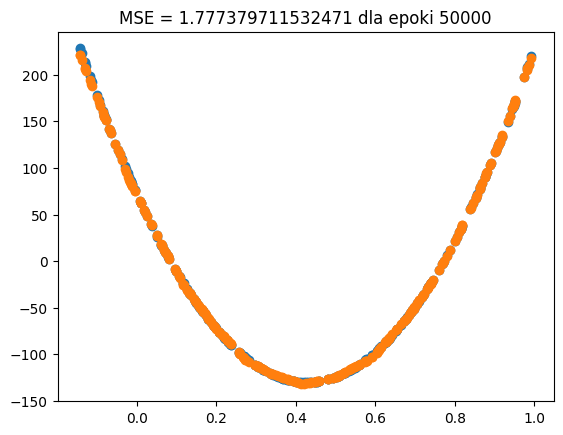

Epoch 50100, Training Loss: 0.000003, test MSE: 1.7767681565864946
Epoch 50200, Training Loss: 0.000003, test MSE: 1.7760125352006633
Epoch 50300, Training Loss: 0.000003, test MSE: 1.776425015579917
Epoch 50400, Training Loss: 0.000003, test MSE: 1.775666743563222
Epoch 50500, Training Loss: 0.000003, test MSE: 1.776038521891912
Epoch 50600, Training Loss: 0.000003, test MSE: 1.775200287081062
Epoch 50700, Training Loss: 0.000003, test MSE: 1.7757583637398762
Epoch 50800, Training Loss: 0.000003, test MSE: 1.7765515349311276
Epoch 50900, Training Loss: 0.000003, test MSE: 1.7758189137372555
Epoch 51000, Training Loss: 0.000003, test MSE: 1.7760808281767808
Epoch 51100, Training Loss: 0.000003, test MSE: 1.7758801060893339
Epoch 51200, Training Loss: 0.000003, test MSE: 1.7767890242077344
Epoch 51300, Training Loss: 0.000003, test MSE: 1.7751502049680006
Epoch 51400, Training Loss: 0.000003, test MSE: 1.776850430091869
Epoch 51500, Training Loss: 0.000003, test MSE: 1.7766214250672456


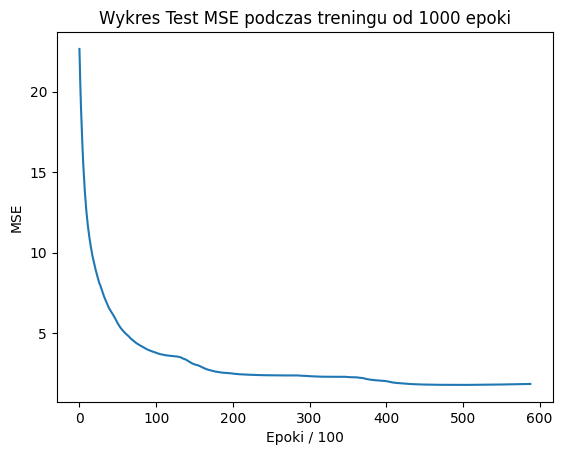

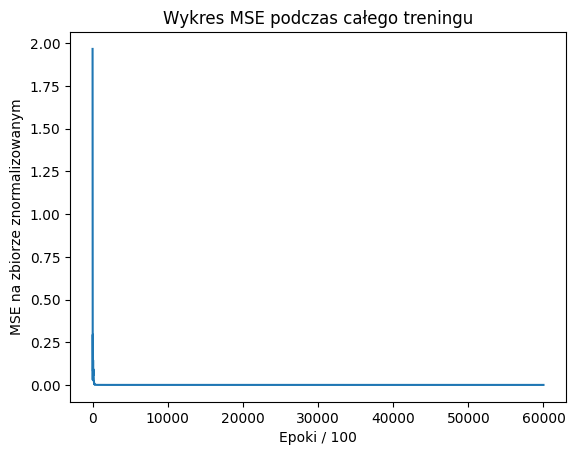

In [1038]:
nn = NeuralNetwork(layers=[1,27,30,1], activation='relu',optimiser='momentum',beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0013, batch_size=512, epochs=60000, mse_threshold=1)


## RMS try1

No optimiser chosen
Epoch 0, Training Loss: 0.068859, test MSE: 12381.92324873493


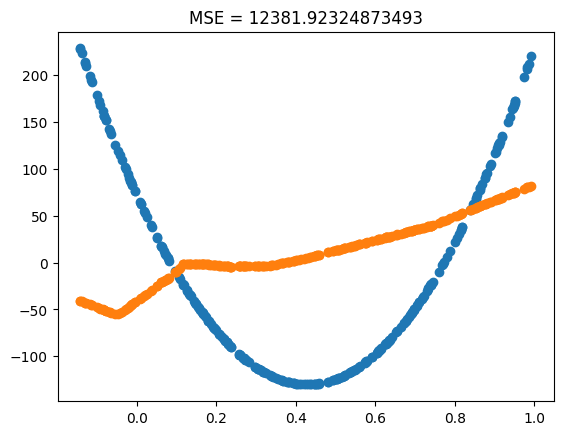

Epoch 100, Training Loss: 0.027639, test MSE: 5659.720713888786
Epoch 200, Training Loss: 0.015594, test MSE: 3085.979142346926
Epoch 300, Training Loss: 0.008148, test MSE: 1541.814360297201
Epoch 400, Training Loss: 0.004192, test MSE: 814.538032143051
Epoch 500, Training Loss: 0.002218, test MSE: 474.5520930802174
Epoch 600, Training Loss: 0.001193, test MSE: 298.3005894338125
Epoch 700, Training Loss: 0.000662, test MSE: 201.38448249656184
Epoch 800, Training Loss: 0.000375, test MSE: 136.0540190988852
Epoch 900, Training Loss: 0.000241, test MSE: 99.92727692532475
Epoch 1000, Training Loss: 0.000155, test MSE: 68.88874079998021
Epoch 1100, Training Loss: 0.000130, test MSE: 60.71760532779211
Epoch 1200, Training Loss: 0.000075, test MSE: 41.66420117979297
Epoch 1300, Training Loss: 0.000071, test MSE: 37.659149498779065
Epoch 1400, Training Loss: 0.000064, test MSE: 31.963850419040543
Epoch 1500, Training Loss: 0.000042, test MSE: 22.909645569295687
Epoch 1600, Training Loss: 0.00

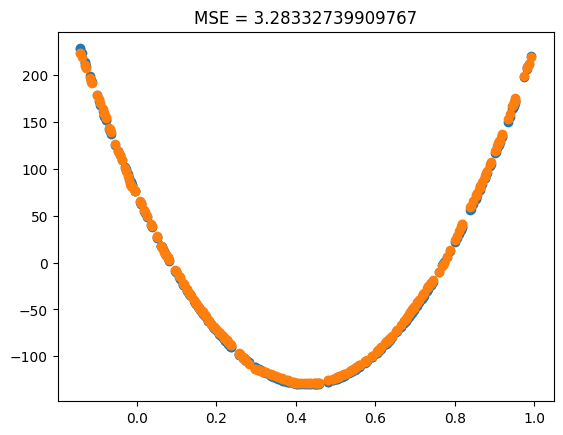

Epoch 10100, Training Loss: 0.000018, test MSE: 2.7675146172568814
Epoch 10200, Training Loss: 0.000014, test MSE: 2.3821348920780068
Epoch 10300, Training Loss: 0.000021, test MSE: 3.1531851684727226
Epoch 10400, Training Loss: 0.000010, test MSE: 1.9166374546946765
Epoch 10500, Training Loss: 0.000011, test MSE: 2.2521043642173844
Epoch 10600, Training Loss: 0.000008, test MSE: 1.6814770549607005
Epoch 10700, Training Loss: 0.000022, test MSE: 3.1632964360751687
Epoch 10800, Training Loss: 0.000008, test MSE: 1.6741632773187816
Epoch 10900, Training Loss: 0.000012, test MSE: 2.280969376410053
Epoch 11000, Training Loss: 0.000006, test MSE: 1.4667859834015577
Epoch 11100, Training Loss: 0.000019, test MSE: 3.048706008603539
Epoch 11200, Training Loss: 0.000020, test MSE: 3.2701015965647167
Epoch 11300, Training Loss: 0.000010, test MSE: 2.0574675105960467
Epoch 11400, Training Loss: 0.000009, test MSE: 1.7880974240374432
Epoch 11500, Training Loss: 0.000011, test MSE: 1.94900699102349

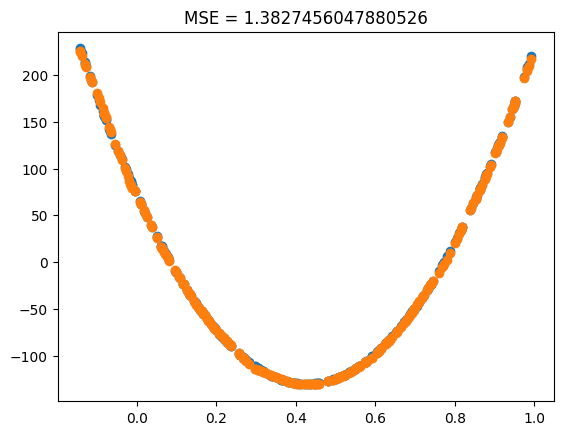

Epoch 20100, Training Loss: 0.000009, test MSE: 1.612927758746075
Epoch 20200, Training Loss: 0.000005, test MSE: 1.2425234925167394
Epoch 20300, Training Loss: 0.000019, test MSE: 3.0053565416189563
Epoch 20400, Training Loss: 0.000012, test MSE: 2.1002726406280203
Epoch 20500, Training Loss: 0.000004, test MSE: 1.1329944886874492
Epoch 20600, Training Loss: 0.000014, test MSE: 2.2280860823266537
Epoch 20700, Training Loss: 0.000008, test MSE: 1.4849911705787588
Epoch 20800, Training Loss: 0.000008, test MSE: 1.5258820089968217
Epoch 20900, Training Loss: 0.000025, test MSE: 3.394886917705005
Epoch 21000, Training Loss: 0.000010, test MSE: 1.9226565067586159
Epoch 21100, Training Loss: 0.000010, test MSE: 1.8769672215239788
Epoch 21200, Training Loss: 0.000027, test MSE: 3.959167202057444
Epoch 21300, Training Loss: 0.000010, test MSE: 1.9285029511199514
Epoch 21400, Training Loss: 0.000004, test MSE: 1.1695228998393132
Epoch 21500, Training Loss: 0.000043, test MSE: 5.398134155139370

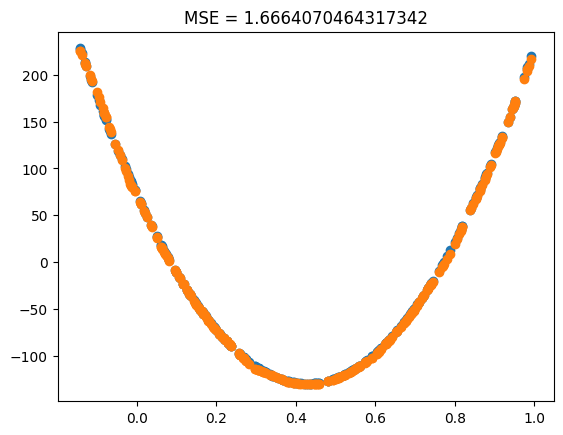

Epoch 30100, Training Loss: 0.000006, test MSE: 1.3660818810246962
Epoch 30200, Training Loss: 0.000006, test MSE: 1.2943990751412495
Epoch 30300, Training Loss: 0.000004, test MSE: 1.1153881321625565
Epoch 30400, Training Loss: 0.000021, test MSE: 3.303468702284426
Epoch 30500, Training Loss: 0.000009, test MSE: 1.9247916406271288
Epoch 30600, Training Loss: 0.000007, test MSE: 1.3871878170492038
Epoch 30700, Training Loss: 0.000006, test MSE: 1.3367558187387631
Epoch 30800, Training Loss: 0.000030, test MSE: 3.9971812649208203
Epoch 30900, Training Loss: 0.000006, test MSE: 1.2863855896603191
Epoch 31000, Training Loss: 0.000010, test MSE: 1.7394043647978796
Epoch 31100, Training Loss: 0.000029, test MSE: 3.786834341330331
Epoch 31200, Training Loss: 0.000023, test MSE: 3.2243850530461464
Epoch 31300, Training Loss: 0.000008, test MSE: 1.554929995139519
Epoch 31400, Training Loss: 0.000005, test MSE: 1.2531898980998775
Epoch 31500, Training Loss: 0.000009, test MSE: 1.648969496429727

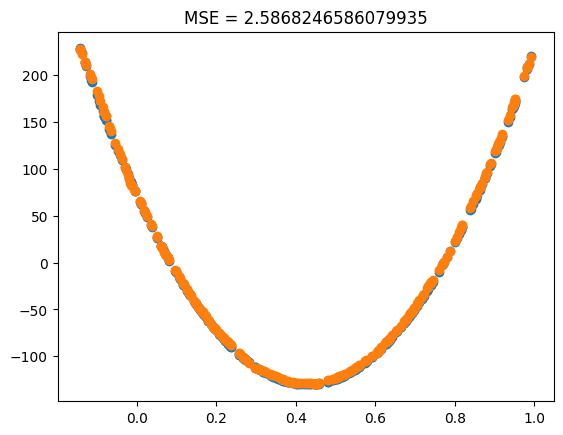

Epoch 40100, Training Loss: 0.000008, test MSE: 1.8125961985264747
Epoch 40200, Training Loss: 0.000005, test MSE: 1.2131521411011545
Epoch 40300, Training Loss: 0.000022, test MSE: 3.081246398825677
Epoch 40400, Training Loss: 0.000024, test MSE: 3.312561764429468
Epoch 40500, Training Loss: 0.000024, test MSE: 3.348981218482894
Epoch 40600, Training Loss: 0.000009, test MSE: 1.6145534402301747
Epoch 40700, Training Loss: 0.000004, test MSE: 1.138339007922014
Epoch 40800, Training Loss: 0.000025, test MSE: 3.927717040286326
Epoch 40900, Training Loss: 0.000014, test MSE: 2.5134408418945937
Epoch 41000, Training Loss: 0.000003, test MSE: 1.1363079745386597
Epoch 41100, Training Loss: 0.000008, test MSE: 1.57713627211173
Epoch 41200, Training Loss: 0.000011, test MSE: 1.8865865006365572
Epoch 41300, Training Loss: 0.000010, test MSE: 1.7220509899711973
Epoch 41400, Training Loss: 0.000015, test MSE: 2.3580098763660158
Epoch 41500, Training Loss: 0.000004, test MSE: 1.2058546424815961
Ep

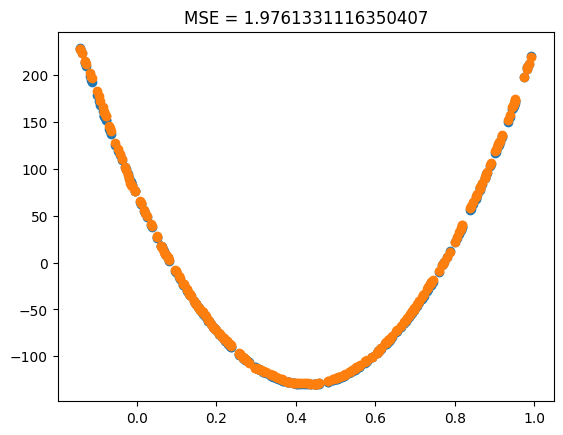

Epoch 50100, Training Loss: 0.000004, test MSE: 1.3459914350474393
Epoch 50200, Training Loss: 0.000013, test MSE: 2.4157084179471915
Epoch 50300, Training Loss: 0.000003, test MSE: 1.083979880522175
Epoch 50400, Training Loss: 0.000009, test MSE: 1.711672806067233
Epoch 50500, Training Loss: 0.000007, test MSE: 1.4913844733107597
Epoch 50600, Training Loss: 0.000006, test MSE: 1.4131773802973597
Epoch 50700, Training Loss: 0.000006, test MSE: 1.379403262310175
Epoch 50800, Training Loss: 0.000006, test MSE: 1.3234449829183785
Epoch 50900, Training Loss: 0.000023, test MSE: 3.1934147133124444
Epoch 51000, Training Loss: 0.000009, test MSE: 1.6994321038991216
Epoch 51100, Training Loss: 0.000003, test MSE: 1.1192447937179801
Epoch 51200, Training Loss: 0.000004, test MSE: 1.1854304154420836
Epoch 51300, Training Loss: 0.000003, test MSE: 1.0800748282478707
Epoch 51400, Training Loss: 0.000012, test MSE: 2.361286738090555
Epoch 51500, Training Loss: 0.000009, test MSE: 1.9757312983547233

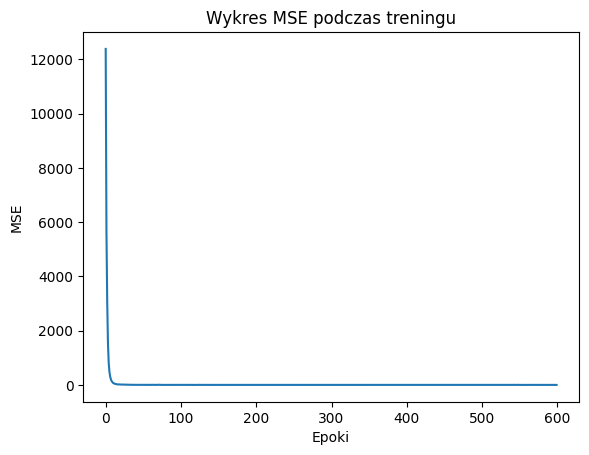

In [326]:
nn = NeuralNetwork(layers=[1,25,30,1], activation='relu',optimiser='RMS',beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0001, batch_size=512, epochs=60000, mse_threshold=1)


In [328]:
Y_pred_denorm=y_scaler.inverse_transform(nn.predict(X_test_normalized))
mse = np.mean((Y_pred_denorm - Y_test) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 1.9028113891811989


## RMS 2 : MSE =1.09

No optimiser chosen
Epoch 0, Training Loss: 0.133836, test MSE: 13198.764129743155


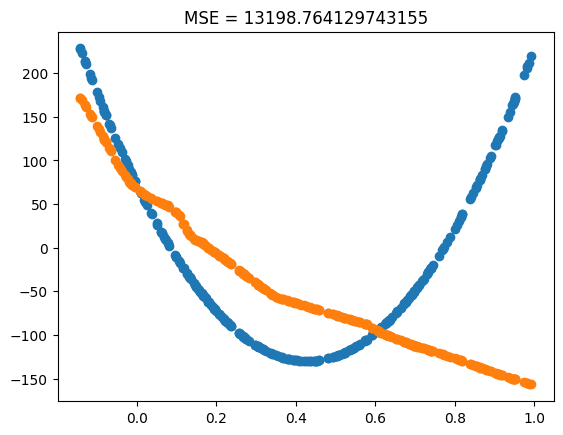

Epoch 100, Training Loss: 0.024159, test MSE: 2672.103101877525
Epoch 200, Training Loss: 0.010918, test MSE: 1205.4055487406804
Epoch 300, Training Loss: 0.006218, test MSE: 718.9961237689877
Epoch 400, Training Loss: 0.003375, test MSE: 400.8852988742203
Epoch 500, Training Loss: 0.001804, test MSE: 209.09477401861955
Epoch 600, Training Loss: 0.000967, test MSE: 105.82918256230383
Epoch 700, Training Loss: 0.000549, test MSE: 55.43590119810101
Epoch 800, Training Loss: 0.000301, test MSE: 27.910149647470316
Epoch 900, Training Loss: 0.000193, test MSE: 19.066994625808686
Epoch 1000, Training Loss: 0.000131, test MSE: 14.819051444597823
Epoch 1100, Training Loss: 0.000098, test MSE: 12.211625228843774
Epoch 1200, Training Loss: 0.000076, test MSE: 10.603267591370724
Epoch 1300, Training Loss: 0.000061, test MSE: 9.132101293998055
Epoch 1400, Training Loss: 0.000063, test MSE: 9.090604274080704
Epoch 1500, Training Loss: 0.000044, test MSE: 7.479596203008306
Epoch 1600, Training Loss:

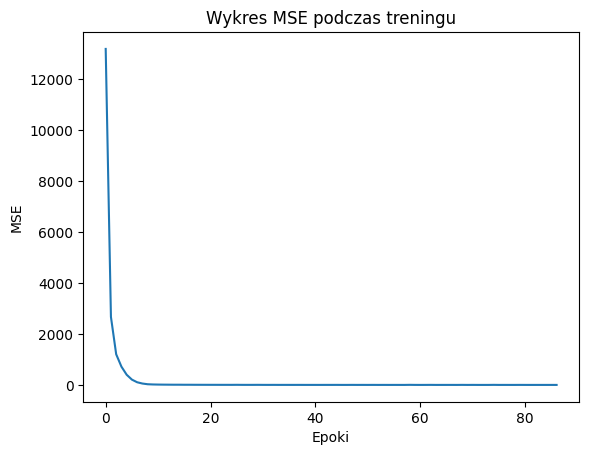

In [557]:
nn = NeuralNetwork(layers=[1,27,33,1], activation='relu',optimiser='RMS',beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0001, batch_size=512, epochs=60000, mse_threshold=1.1)


## Steps large

In [157]:
train_df = pd.read_csv('data/steps-large-training.csv')
test_df = pd.read_csv('data/steps-large-test.csv')


X_train, Y_train=train_df['x'].to_numpy().reshape(-1,1), train_df['y'].to_numpy().reshape(-1,1)
X_test, Y_test=test_df['x'].to_numpy().reshape(-1,1), test_df['y'].to_numpy().reshape(-1,1)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_normalized = x_scaler.fit_transform(X_train.reshape(-1, 1))
Y_train_normalized = y_scaler.fit_transform(Y_train.reshape(-1, 1))

X_test_normalized = x_scaler.transform(X_test.reshape(-1,1))
Y_test_normalized = y_scaler.transform(Y_test.reshape(-1,1))

No optimiser chosen
Epoch 0, Training Loss: 0.069492, test MSE: 4075.9060815395583


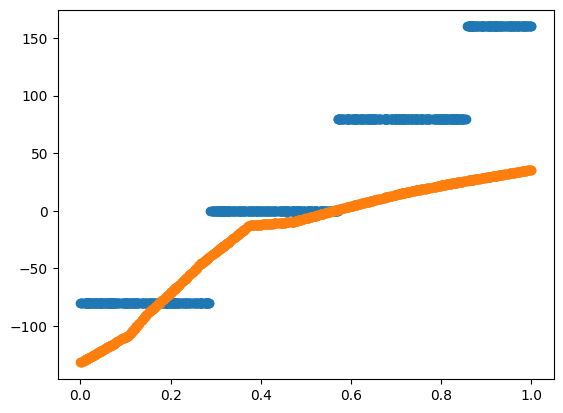

Epoch 100, Training Loss: 0.006348, test MSE: 367.17729612544554
Epoch 200, Training Loss: 0.006080, test MSE: 351.35672141427654
Epoch 300, Training Loss: 0.005840, test MSE: 336.86092448852213
Epoch 400, Training Loss: 0.005669, test MSE: 327.35463010909024
Epoch 500, Training Loss: 0.005483, test MSE: 316.1691537942806
Epoch 600, Training Loss: 0.005350, test MSE: 307.2944415794655
Epoch 700, Training Loss: 0.005233, test MSE: 301.98173713972454
Epoch 800, Training Loss: 0.005169, test MSE: 298.92957681923326
Epoch 900, Training Loss: 0.005124, test MSE: 296.78308240030594
Epoch 1000, Training Loss: 0.005011, test MSE: 290.06414650018127
Epoch 1100, Training Loss: 0.004929, test MSE: 283.69569942115015
Epoch 1200, Training Loss: 0.004859, test MSE: 281.06079726583783
Epoch 1300, Training Loss: 0.004963, test MSE: 288.56991594898284
Epoch 1400, Training Loss: 0.004789, test MSE: 276.1613655182788
Epoch 1500, Training Loss: 0.004717, test MSE: 273.1307988257593
Epoch 1600, Training Lo

KeyboardInterrupt: 

In [271]:
nn = NeuralNetwork(layers=[1,35,35,1], activation='relu',optimiser='RMS',beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0001, batch_size=512, epochs=20000, mse_threshold=3)
